In [ ]:
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm

# Train.csv 확인

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/alpaco/main_project/kaggle/train.csv')
df

,id,organ,data_source,img_height,img_width,pixel_size,tissue_thickness,rle,age,sex
0,10044,prostate,HPA,3000,3000,0.4,4,1459676 77 1462675 82 1465674 87 1468673 92 14...,37.0,Male
1,10274,prostate,HPA,3000,3000,0.4,4,715707 2 718705 8 721703 11 724701 18 727692 3...,76.0,Male
2,10392,spleen,HPA,3000,3000,0.4,4,1228631 20 1231629 24 1234624 40 1237623 47 12...,82.0,Male
3,10488,lung,HPA,3000,3000,0.4,4,3446519 15 3449517 17 3452514 20 3455510 24 34...,78.0,Male
4,10610,spleen,HPA,3000,3000,0.4,4,478925 68 481909 87 484893 105 487863 154 4908...,21.0,Female
...,...,...,...,...,...,...,...,...,...,...
346,9517,kidney,HPA,3000,3000,0.4,4,1611763 11 1614753 29 1617750 35 1620746 43 16...,61.0,Male
347,9769,kidney,HPA,3070,3070,0.4,4,4030400 28 4033466 34 4036526 48 4039594 54 40...,28.0,Male
348,9777,largeintestine,HPA,3000,3000,0.4,4,538473 13 541468 22 544463 30 547461 35 550459...,84.0,Male
349,9791,kidney,HPA,3000,3000,0.4,4,334733 33 337729 43 340729 43 343725 51 346723...,28.0,Male


# rle로 mask image 생성

In [ ]:
df['rle'][0]

'1459676 77 1462675 82 1465674 87 1468673 92 1471671 97 1474669 101 1477667 105 1480665 109 1483664 115 1486662 119 1489661 121 1492659 125 1495658 127 1498656 131 1501655 133 1504653 137 1507652 139 1510651 140 1513650 142 1516649 143 1519648 145 1522647 146 1525646 148 1528645 149 1531644 151 1534643 152 1537642 153 1540641 155 1543640 156 1546639 157 1549638 158 1552637 160 1555636 161 1558635 162 1561634 163 1564633 165 1567631 167 1570628 171 1573625 175 1576622 179 1579620 182 1582619 184 1585618 186 1588617 188 1591616 190 1594615 191 1597615 191 1600614 192 1603613 193 1606612 194 1609611 195 1612610 196 1615609 197 1618607 200 1621606 202 1624604 205 1627603 207 1630601 211 1633600 213 1636599 215 1639597 218 1642596 220 1645594 223 1648592 226 1651590 228 1654588 230 1657586 232 1660584 234 1663582 236 1666580 238 1669578 240 1672577 241 1675576 242 1678575 244 1681574 245 1684573 246 1687572 248 1690571 249 1693570 250 1696569 252 1699568 253 1702567 254 1705566 256 1708566 

In [ ]:
def mask2rle(img):
    """
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formatted
    """
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_encode_less_memory(img):
    pixels = img.T.flatten()
    pixels[0] = 0
    pixels[-1] = 0
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 2
    runs[1::2] -= runs[::2]    
    return ' '.join(str(x) for x in runs)

def rle2mask(mask_rle: str, label=1, shape=(3000, 3000)):
    """
    mask_rle: run-length as string formatted (start length)
    shape: (height,width) of array to return
    Returns numpy array, 1 - mask, 0 - background

    """
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = label
    return img.reshape(shape)  # Needed to align to RLE direction

## Test

In [ ]:
pd.describe_option()
pd.set_option('display.max_columns', 20)

In [ ]:
test_list = [0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0]
test = np.concatenate([[0], test_list, [0]])

In [ ]:
test = np.concatenate([[0], test_list, [0]])

In [ ]:
a = test[1:]
b = test[:-1]
c = test[1:] != test[:-1]

In [ ]:
print(a)
print(b)
print(c)

[0 0 1 1 1 0 0 0 1 1 1 1 1 0 0 1 0 0]
[0 0 0 1 1 1 0 0 0 1 1 1 1 1 0 0 1 0]
[False False  True False False  True False False  True False False False
 False  True False  True  True False]


In [ ]:
dic = {
    'c_data' : a,
    'o_data' : b,
    'bool' : c
}
df = pd.DataFrame(dic)
df.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
c_data,0,0,1,1,1,0,0,0,1,1,1,1,1,0,0,1,0,0
o_data,0,0,0,1,1,1,0,0,0,1,1,1,1,1,0,0,1,0
bool,False,False,True,False,False,True,False,False,True,False,False,False,False,True,False,True,True,False


In [ ]:
mask_img = rle2mask(df['rle'][0], shape=(3000, 3000))

In [ ]:
import matplotlib.pyplot as plt
import cv2
from PIL import Image

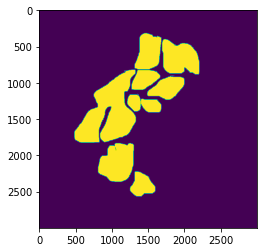

In [ ]:
plt.imshow(mask_img.T)

In [ ]:
df.loc[1]

id                                                              10274
organ                                                        prostate
data_source                                                       HPA
img_height                                                       3000
img_width                                                        3000
pixel_size                                                        0.4
tissue_thickness                                                    4
rle                 715707 2 718705 8 721703 11 724701 18 727692 3...
age                                                              76.0
sex                                                              Male
Name: 1, dtype: object

# Make mask image

In [ ]:
!mkdir /content/mask_img

In [ ]:
for idx in range(len(df)):
    img_id = df.loc[idx]['id']
    img_h = df.loc[idx]['img_height']
    img_w = df.loc[idx]['img_width']
    img_rle = df.loc[idx]['rle']

    mask_img = rle2mask(img_rle, shape=(img_w, img_h))
    mask_img = Image.fromarray(mask_img)
    mask_img.save(f'/content/mask_img/{img_id}.png')
    # plt.imshow(mask_img.T)
    # print(img_id)
    # plt.show()

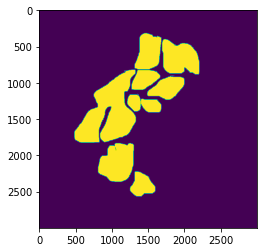

In [ ]:
test_mask = Image.open('/content/mask_img/10044.png')
test_mask = np.array(test_mask)
plt.imshow(test_mask * 255)

In [ ]:
!zip mask_img.zip ./mask_img/*

# Image Crop 

In [ ]:
!gdown 1VnXyPKFiRL5Cvmw3UXLIK6Id93vjgKW5

In [ ]:
!unzip /content/hubmap-organ-segmentation.zip -d /content/origin_data

In [ ]:
!mkdir /content/crop_dataset
!mkdir /content/crop_dataset/images
!mkdir /content/crop_dataset/masks

In [ ]:
img_path = '/content/origin_data/train_images/'
mask_path = '/content/mask_img/'

img_name_list = os.listdir(img_path)

for img in tqdm(img_name_list):
    name = img.split('.')[0]
    mask_img = name + '.png'

    origin_img = Image.open(img_path + img)
    mask_img = Image.open(mask_path + mask_img)

    h, w = origin_img.size
    crop_start_x = (h - 2000) / 2
    crop_start_y = (w - 2000) / 2
    crop_end_x = 2000 + crop_start_x
    crop_end_y = 2000 + crop_start_y

    crop_img = origin_img.crop((crop_start_x, crop_start_y, crop_end_x, crop_end_y))
    crop_mask = mask_img.crop((crop_start_x, crop_start_y, crop_end_x, crop_end_y))

    crop_img.save(f'/content/crop_dataset/images/{name}.jpg')
    crop_mask.save(f'/content/crop_dataset/masks/{name}.png')

  0%|          | 0/351 [00:00<?, ?it/s]

## Check image

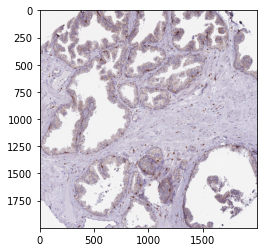

In [ ]:
test_mask = Image.open('/content/crop_dataset/images/10044.jpg')
plt.imshow(test_mask)

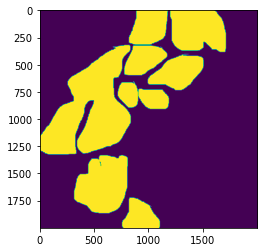

In [ ]:
test_image = Image.open('/content/crop_dataset/masks/10044.png')
plt.imshow(test_image)

In [ ]:
!zip -r /content/hubmap_binary_2000x2000_crop_dataset_220818.zip ./crop_dataset/*

updating: crop_dataset/images/ (stored 0%)
updating: crop_dataset/masks/ (stored 0%)
  adding: crop_dataset/images/11629.jpg (deflated 1%)
  adding: crop_dataset/images/27879.jpg (deflated 0%)
  adding: crop_dataset/images/26319.jpg (deflated 0%)
  adding: crop_dataset/images/24194.jpg (deflated 0%)
  adding: crop_dataset/images/21039.jpg (deflated 0%)
  adding: crop_dataset/images/29223.jpg (deflated 0%)
  adding: crop_dataset/images/28657.jpg (deflated 0%)
  adding: crop_dataset/images/4062.jpg (deflated 0%)
  adding: crop_dataset/images/28436.jpg (deflated 0%)
  adding: crop_dataset/images/26480.jpg (deflated 0%)
  adding: crop_dataset/images/3057.jpg (deflated 0%)
  adding: crop_dataset/images/30394.jpg (deflated 0%)
  adding: crop_dataset/images/20794.jpg (deflated 0%)
  adding: crop_dataset/images/10912.jpg (deflated 0%)
  adding: crop_dataset/images/12827.jpg (deflated 1%)
  adding: crop_dataset/images/16362.jpg (deflated 0%)
  adding: crop_dataset/images/5832.jpg (deflated 0%)
